# Image Captioning - Model Training

In this notebook, we will train the image captioning model using the pre-extracted features from the CNN encoder. We will:

1. Set up the data loaders for training and validation
2. Build the caption model (combining the encoder and decoder)
3. Define the training pipeline with teacher forcing
4. Train the model with appropriate hyperparameters
5. Monitor the training progress and validation performance
6. Save the trained model for later evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import time
import h5py

# Add project root to path
sys.path.append('/content/drive/MyDrive/image_captioning/image-captioning')


# Import project modules
from models.encoder import EncoderCNN
from models.decoder import DecoderRNN
from models.caption_model import CaptionModel
from utils.vocabulary import Vocabulary
from utils.dataset import get_data_loaders
from utils.trainer import CaptionTrainer

## 1. Configuration Settings

In [ ]:
# Define configuration settings
config = {
    # Data settings
    'data_dir': '/content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k',
    'batch_size': 32,
    'num_workers': 4,

    # Model settings
    'encoder_model': 'resnet18',  # Options: 'resnet18', 'resnet50', 'mobilenet_v2'
    'embed_size': 256,
    'hidden_size': 512,
    'num_layers': 1,
    'dropout': 0.5,
    'decoder_type': 'lstm',  # Options: 'lstm', 'gru'

    # Training settings
    'learning_rate': 3e-4,
    'num_epochs': 5,  # Increase for better results
    'early_stopping_patience': 5,
    'save_dir':'/content/drive/MyDrive/image_captioning/image-captioning/models' ,

    # Device settings
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Create save directory if it doesn't exist
os.makedirs(config['save_dir'], exist_ok=True)

# Print configuration
for section, items in {
    'Data': ['data_dir', 'batch_size', 'num_workers'],
    'Model': ['encoder_model', 'embed_size', 'hidden_size', 'num_layers', 'dropout', 'decoder_type'],
    'Training': ['learning_rate', 'num_epochs', 'early_stopping_patience', 'save_dir'],
    'Device': ['device']
}.items():
    print(f"\n{section} settings:")
    for item in items:
        print(f"  {item}: {config[item]}")


Data settings:
  data_dir: /content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k
  batch_size: 32
  num_workers: 4

Model settings:
  encoder_model: resnet18
  embed_size: 256
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm

Training settings:
  learning_rate: 0.0003
  num_epochs: 5
  early_stopping_patience: 5
  save_dir: /content/drive/MyDrive/image_captioning/image-captioning/models

Device settings:
  device: cpu


## 2. Load Data

In [ ]:
# Get data loaders
train_loader, val_loader, test_loader, vocab = get_data_loaders(
    data_dir=config['data_dir'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers']
)

# Update vocabulary size in config
config['vocab_size'] = len(vocab)
print(f"Vocabulary size: {config['vocab_size']}")

# Display data loader information
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Vocabulary size: 2986
Training batches: 1264
Validation batches: 157
Test batches: 5000


## 3. Create Model

In [ ]:
# Create caption model
model = CaptionModel(
    embed_size=config['embed_size'],
    hidden_size=config['hidden_size'],
    vocab_size=config['vocab_size'],
    num_layers=config['num_layers'],
    encoder_model=config['encoder_model'],
    decoder_type=config['decoder_type'],
    dropout=config['dropout'],
    train_encoder=False  # Don't train the encoder (use pre-trained weights)
)

# Print model architecture
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.8MB/s]


CaptionModel(
  (encoder): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1

In [ ]:
# Calculate model size
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    num_of_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_of_trainable_parameters

# Calculate and print model size
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params:,}")

# Calculate encoder and decoder sizes separately
encoder_params = count_parameters(model.encoder)
decoder_params = count_parameters(model.decoder)
print(f"Encoder parameters: {encoder_params:,} ({encoder_params / num_params * 100:.1f}%)")
print(f"Decoder parameters: {decoder_params:,} ({decoder_params / num_params * 100:.1f}%)")

Number of trainable parameters: 4,004,522
Encoder parameters: 131,328 (3.3%)
Decoder parameters: 3,873,194 (96.7%)


## 4. Train the Model

In [ ]:
# Create trainer
trainer = CaptionTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    device=config['device'],
    learning_rate=config['learning_rate'],
    model_save_dir=config['save_dir']
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Train the model
history = trainer.train(
    epochs=config['num_epochs'],
    early_stopping_patience=config['early_stopping_patience'],
    evaluate_every=1,
    generate_every=5  # Generate captions and calculate BLEU every 5 epochs
)

Loading latest checkpoint from /content/drive/MyDrive/image_captioning/image-captioning/models/latest_model.pth
Resuming from epoch 4
Starting training for 5 epochs (from epoch 4) on cpu


Epoch 5:   0%|          | 0/1264 [00:00<?, ?it/s]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   0%|          | 1/1264 [00:15<5:27:55, 15.58s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   0%|          | 2/1264 [00:28<4:59:14, 14.23s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   0%|          | 3/1264 [00:42<4:50:22, 13.82s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   0%|          | 4/1264 [00:54<4:37:09, 13.20s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   0%|          | 5/1264 [01:06<4:31:20, 12.93s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   0%|          | 6/1264 [01:17<4:17:58, 12.30s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|          | 7/1264 [01:34<4:43:29, 13.53s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|          | 8/1264 [01:47<4:44:40, 13.60s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|          | 9/1264 [02:04<5:06:17, 14.64s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|          | 10/1264 [02:20<5:11:24, 14.90s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|          | 11/1264 [02:35<5:14:43, 15.07s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|          | 12/1264 [02:46<4:50:36, 13.93s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|          | 13/1264 [02:58<4:33:38, 13.12s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|          | 14/1264 [03:11<4:33:34, 13.13s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|          | 15/1264 [03:22<4:20:24, 12.51s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|▏         | 16/1264 [03:43<5:10:37, 14.93s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|▏         | 17/1264 [04:02<5:37:25, 16.24s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   1%|▏         | 18/1264 [04:14<5:09:11, 14.89s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 19/1264 [04:24<4:44:02, 13.69s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 20/1264 [04:41<5:04:08, 14.67s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 21/1264 [04:53<4:44:17, 13.72s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 22/1264 [05:04<4:29:31, 13.02s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 23/1264 [05:17<4:26:14, 12.87s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 24/1264 [05:30<4:25:01, 12.82s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 25/1264 [05:42<4:25:04, 12.84s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 26/1264 [05:54<4:19:11, 12.56s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 27/1264 [06:11<4:42:33, 13.71s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 28/1264 [06:22<4:26:00, 12.91s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 29/1264 [06:33<4:17:09, 12.49s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 30/1264 [06:52<4:55:08, 14.35s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   2%|▏         | 31/1264 [07:04<4:43:39, 13.80s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 32/1264 [07:19<4:47:36, 14.01s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 33/1264 [07:31<4:35:56, 13.45s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 34/1264 [07:44<4:32:35, 13.30s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 35/1264 [08:05<5:21:20, 15.69s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 36/1264 [08:18<5:04:09, 14.86s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 37/1264 [08:31<4:52:44, 14.31s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 38/1264 [08:43<4:38:08, 13.61s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 39/1264 [08:53<4:16:10, 12.55s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 40/1264 [09:05<4:11:26, 12.33s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 41/1264 [09:18<4:14:40, 12.49s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 42/1264 [09:34<4:37:52, 13.64s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 43/1264 [09:48<4:37:08, 13.62s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   3%|▎         | 44/1264 [10:01<4:31:05, 13.33s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▎         | 45/1264 [10:11<4:12:42, 12.44s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▎         | 46/1264 [10:24<4:14:17, 12.53s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▎         | 47/1264 [10:35<4:06:24, 12.15s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▍         | 48/1264 [10:48<4:14:37, 12.56s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▍         | 49/1264 [10:58<3:58:52, 11.80s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▍         | 50/1264 [11:10<3:55:58, 11.66s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▍         | 51/1264 [11:20<3:45:33, 11.16s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▍         | 52/1264 [11:31<3:45:59, 11.19s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▍         | 53/1264 [11:43<3:52:05, 11.50s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▍         | 54/1264 [11:57<4:04:47, 12.14s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▍         | 55/1264 [12:09<4:05:51, 12.20s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   4%|▍         | 56/1264 [12:21<4:05:38, 12.20s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▍         | 57/1264 [12:33<3:59:59, 11.93s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▍         | 58/1264 [12:43<3:52:18, 11.56s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▍         | 59/1264 [12:53<3:40:27, 10.98s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▍         | 60/1264 [13:05<3:46:05, 11.27s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▍         | 61/1264 [13:16<3:44:42, 11.21s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▍         | 62/1264 [13:28<3:46:29, 11.31s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▍         | 63/1264 [13:40<3:55:50, 11.78s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▌         | 64/1264 [13:53<4:01:21, 12.07s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▌         | 65/1264 [14:09<4:24:20, 13.23s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▌         | 66/1264 [14:21<4:13:35, 12.70s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▌         | 67/1264 [14:32<4:05:20, 12.30s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▌         | 68/1264 [14:50<4:38:31, 13.97s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   5%|▌         | 69/1264 [15:01<4:22:32, 13.18s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▌         | 70/1264 [15:12<4:07:16, 12.43s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▌         | 71/1264 [15:23<3:57:38, 11.95s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▌         | 72/1264 [15:32<3:43:03, 11.23s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▌         | 73/1264 [15:42<3:35:14, 10.84s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▌         | 74/1264 [15:52<3:29:44, 10.58s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▌         | 75/1264 [16:04<3:36:13, 10.91s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▌         | 76/1264 [16:15<3:38:04, 11.01s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▌         | 77/1264 [16:26<3:34:36, 10.85s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▌         | 78/1264 [16:40<3:53:44, 11.82s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▋         | 79/1264 [16:49<3:39:49, 11.13s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▋         | 80/1264 [17:00<3:35:10, 10.90s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▋         | 81/1264 [17:13<3:49:46, 11.65s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   6%|▋         | 82/1264 [17:22<3:33:41, 10.85s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 83/1264 [17:32<3:30:56, 10.72s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 84/1264 [17:46<3:45:24, 11.46s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 85/1264 [17:57<3:42:57, 11.35s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 86/1264 [18:07<3:35:37, 10.98s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 87/1264 [18:16<3:23:47, 10.39s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 88/1264 [18:27<3:26:35, 10.54s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 89/1264 [18:38<3:32:32, 10.85s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 90/1264 [18:49<3:33:19, 10.90s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 91/1264 [18:59<3:24:15, 10.45s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 92/1264 [19:09<3:23:26, 10.41s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 93/1264 [19:22<3:37:49, 11.16s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   7%|▋         | 94/1264 [19:34<3:45:35, 11.57s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 95/1264 [19:47<3:49:50, 11.80s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 96/1264 [20:00<4:00:02, 12.33s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 97/1264 [20:11<3:52:55, 11.98s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 98/1264 [20:22<3:46:46, 11.67s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 99/1264 [20:33<3:39:43, 11.32s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 100/1264 [20:44<3:38:23, 11.26s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 101/1264 [20:57<3:50:06, 11.87s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 102/1264 [21:09<3:48:25, 11.79s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 103/1264 [21:18<3:30:05, 10.86s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 104/1264 [21:31<3:47:29, 11.77s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 105/1264 [21:44<3:50:36, 11.94s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 106/1264 [21:56<3:52:36, 12.05s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   8%|▊         | 107/1264 [22:07<3:46:09, 11.73s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▊         | 108/1264 [22:19<3:46:44, 11.77s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▊         | 109/1264 [22:29<3:36:00, 11.22s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▊         | 110/1264 [22:42<3:44:41, 11.68s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 111/1264 [22:51<3:32:29, 11.06s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 112/1264 [23:00<3:20:40, 10.45s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 113/1264 [23:12<3:27:48, 10.83s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 114/1264 [23:21<3:16:16, 10.24s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 115/1264 [23:32<3:21:59, 10.55s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 116/1264 [23:47<3:46:31, 11.84s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 117/1264 [24:04<4:15:46, 13.38s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 118/1264 [24:15<4:02:44, 12.71s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 119/1264 [24:23<3:36:29, 11.34s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:   9%|▉         | 120/1264 [24:33<3:27:04, 10.86s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|▉         | 121/1264 [24:43<3:23:58, 10.71s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|▉         | 122/1264 [24:53<3:18:51, 10.45s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|▉         | 123/1264 [25:05<3:26:20, 10.85s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|▉         | 124/1264 [25:15<3:20:23, 10.55s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|▉         | 125/1264 [25:25<3:16:15, 10.34s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|▉         | 126/1264 [25:33<3:04:19,  9.72s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|█         | 127/1264 [25:43<3:03:03,  9.66s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|█         | 128/1264 [25:51<2:54:16,  9.20s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|█         | 129/1264 [25:59<2:50:29,  9.01s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|█         | 130/1264 [26:11<3:04:14,  9.75s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|█         | 131/1264 [26:19<2:57:33,  9.40s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  10%|█         | 132/1264 [26:28<2:52:58,  9.17s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 133/1264 [26:39<3:01:59,  9.65s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 134/1264 [26:50<3:12:42, 10.23s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 135/1264 [26:58<2:59:07,  9.52s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 136/1264 [27:07<2:53:51,  9.25s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 137/1264 [27:22<3:25:39, 10.95s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 138/1264 [27:34<3:31:04, 11.25s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 139/1264 [27:42<3:17:40, 10.54s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 140/1264 [27:53<3:18:36, 10.60s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 141/1264 [28:03<3:14:09, 10.37s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█         | 142/1264 [28:11<2:59:03,  9.58s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█▏        | 143/1264 [28:22<3:09:47, 10.16s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█▏        | 144/1264 [28:33<3:12:59, 10.34s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  11%|█▏        | 145/1264 [28:42<3:06:02,  9.98s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 146/1264 [28:51<3:01:57,  9.77s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 147/1264 [29:00<2:54:47,  9.39s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 148/1264 [29:12<3:10:14, 10.23s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 149/1264 [29:22<3:07:33, 10.09s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 150/1264 [29:32<3:04:39,  9.95s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 151/1264 [29:40<2:57:55,  9.59s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 152/1264 [29:51<3:06:38, 10.07s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 153/1264 [30:00<3:00:19,  9.74s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 154/1264 [30:10<3:01:18,  9.80s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 155/1264 [30:20<2:57:50,  9.62s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 156/1264 [30:28<2:51:47,  9.30s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▏        | 157/1264 [30:36<2:46:06,  9.00s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  12%|█▎        | 158/1264 [30:45<2:44:44,  8.94s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 159/1264 [30:53<2:40:30,  8.72s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 160/1264 [31:06<3:00:11,  9.79s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 161/1264 [31:14<2:49:38,  9.23s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 162/1264 [31:22<2:45:29,  9.01s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 163/1264 [31:30<2:38:20,  8.63s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 164/1264 [31:44<3:05:36, 10.12s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 165/1264 [31:51<2:48:38,  9.21s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 166/1264 [32:00<2:51:53,  9.39s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 168/1264 [32:25<3:17:33, 10.82s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 169/1264 [32:33<2:59:35,  9.84s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  13%|█▎        | 170/1264 [32:42<2:56:02,  9.66s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▎        | 171/1264 [32:50<2:50:10,  9.34s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▎        | 172/1264 [33:01<2:57:36,  9.76s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▎        | 173/1264 [33:10<2:54:13,  9.58s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 174/1264 [33:19<2:49:00,  9.30s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 175/1264 [33:30<2:56:26,  9.72s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 176/1264 [33:41<3:03:35, 10.12s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 177/1264 [33:51<3:01:10, 10.00s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 178/1264 [34:02<3:08:50, 10.43s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 179/1264 [34:15<3:23:33, 11.26s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 180/1264 [34:23<3:05:58, 10.29s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 181/1264 [34:35<3:16:12, 10.87s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 182/1264 [34:43<2:58:21,  9.89s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  14%|█▍        | 183/1264 [34:52<2:55:49,  9.76s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▍        | 184/1264 [35:01<2:47:12,  9.29s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▍        | 185/1264 [35:13<3:01:20, 10.08s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▍        | 186/1264 [35:20<2:45:15,  9.20s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▍        | 187/1264 [35:31<2:54:10,  9.70s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▍        | 188/1264 [35:40<2:53:28,  9.67s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▍        | 189/1264 [35:49<2:49:26,  9.46s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▌        | 190/1264 [35:58<2:44:59,  9.22s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▌        | 191/1264 [36:08<2:50:43,  9.55s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▌        | 192/1264 [36:18<2:51:25,  9.59s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▌        | 193/1264 [36:27<2:49:42,  9.51s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▌        | 194/1264 [36:38<2:56:32,  9.90s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  15%|█▌        | 195/1264 [36:45<2:43:27,  9.17s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 196/1264 [36:55<2:47:41,  9.42s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 197/1264 [37:06<2:53:15,  9.74s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 198/1264 [37:14<2:43:05,  9.18s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 199/1264 [37:26<2:59:02, 10.09s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 200/1264 [37:34<2:48:13,  9.49s/it, loss=2.72]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 201/1264 [37:43<2:45:26,  9.34s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 202/1264 [37:52<2:45:31,  9.35s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 203/1264 [37:59<2:31:56,  8.59s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 204/1264 [38:07<2:26:55,  8.32s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▌        | 205/1264 [38:15<2:26:06,  8.28s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▋        | 206/1264 [38:23<2:22:10,  8.06s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▋        | 207/1264 [38:32<2:27:16,  8.36s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  16%|█▋        | 208/1264 [38:46<2:56:36, 10.03s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 209/1264 [38:56<2:57:41, 10.11s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 210/1264 [39:05<2:51:40,  9.77s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 211/1264 [39:14<2:46:38,  9.50s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 212/1264 [39:24<2:52:17,  9.83s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 213/1264 [39:31<2:36:40,  8.94s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 214/1264 [39:40<2:33:33,  8.78s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 215/1264 [39:48<2:29:21,  8.54s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 216/1264 [39:54<2:18:41,  7.94s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 217/1264 [40:05<2:35:18,  8.90s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 218/1264 [40:15<2:40:16,  9.19s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 219/1264 [40:23<2:30:50,  8.66s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 220/1264 [40:31<2:29:46,  8.61s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  17%|█▋        | 221/1264 [40:40<2:32:17,  8.76s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 222/1264 [40:48<2:25:29,  8.38s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 223/1264 [40:56<2:23:39,  8.28s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 224/1264 [41:03<2:19:35,  8.05s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 225/1264 [41:15<2:38:09,  9.13s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 226/1264 [41:24<2:36:56,  9.07s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 227/1264 [41:33<2:38:05,  9.15s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 228/1264 [41:43<2:42:40,  9.42s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 229/1264 [41:52<2:37:07,  9.11s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 230/1264 [42:02<2:45:56,  9.63s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 231/1264 [42:08<2:25:15,  8.44s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 232/1264 [42:16<2:24:37,  8.41s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  18%|█▊        | 233/1264 [42:25<2:26:44,  8.54s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▊        | 234/1264 [42:34<2:25:26,  8.47s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▊        | 235/1264 [42:43<2:30:43,  8.79s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▊        | 236/1264 [42:51<2:25:58,  8.52s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 237/1264 [42:58<2:15:47,  7.93s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 238/1264 [43:06<2:18:25,  8.09s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 239/1264 [43:14<2:16:12,  7.97s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 240/1264 [43:21<2:10:13,  7.63s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 241/1264 [43:28<2:09:10,  7.58s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 242/1264 [43:34<2:01:33,  7.14s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 243/1264 [43:45<2:19:35,  8.20s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 244/1264 [43:51<2:08:47,  7.58s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 245/1264 [43:57<2:03:06,  7.25s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  19%|█▉        | 246/1264 [44:09<2:23:32,  8.46s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|█▉        | 247/1264 [44:16<2:17:09,  8.09s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|█▉        | 248/1264 [44:24<2:14:02,  7.92s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|█▉        | 249/1264 [44:29<2:03:50,  7.32s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|█▉        | 250/1264 [44:37<2:04:34,  7.37s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|█▉        | 251/1264 [44:44<2:04:09,  7.35s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|█▉        | 252/1264 [44:51<1:59:18,  7.07s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|██        | 253/1264 [45:00<2:08:37,  7.63s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|██        | 254/1264 [45:06<2:03:29,  7.34s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|██        | 255/1264 [45:13<2:00:36,  7.17s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|██        | 256/1264 [45:19<1:56:33,  6.94s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|██        | 257/1264 [45:27<2:01:40,  7.25s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|██        | 258/1264 [45:35<2:01:41,  7.26s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  20%|██        | 259/1264 [45:42<2:03:53,  7.40s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██        | 260/1264 [45:49<1:59:09,  7.12s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██        | 261/1264 [45:56<1:59:27,  7.15s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██        | 262/1264 [46:01<1:50:38,  6.63s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██        | 263/1264 [46:10<2:01:28,  7.28s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██        | 264/1264 [46:17<1:59:13,  7.15s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██        | 265/1264 [46:26<2:10:01,  7.81s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██        | 266/1264 [46:34<2:08:37,  7.73s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██        | 267/1264 [46:40<2:00:08,  7.23s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██        | 268/1264 [46:48<2:02:35,  7.38s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██▏       | 269/1264 [46:54<1:58:06,  7.12s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██▏       | 270/1264 [47:01<1:55:49,  6.99s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  21%|██▏       | 271/1264 [47:07<1:49:15,  6.60s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 272/1264 [47:15<1:58:24,  7.16s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 273/1264 [47:22<1:55:52,  7.02s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 274/1264 [47:29<1:57:22,  7.11s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 275/1264 [47:37<1:58:26,  7.19s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 276/1264 [47:45<2:06:02,  7.65s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 277/1264 [47:58<2:28:14,  9.01s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 278/1264 [48:05<2:19:20,  8.48s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 279/1264 [48:14<2:22:41,  8.69s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 280/1264 [48:22<2:19:26,  8.50s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 281/1264 [48:29<2:12:22,  8.08s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 282/1264 [48:35<2:01:51,  7.45s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 283/1264 [48:43<2:02:57,  7.52s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  22%|██▏       | 284/1264 [48:51<2:04:01,  7.59s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 285/1264 [48:59<2:07:03,  7.79s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 286/1264 [49:07<2:07:25,  7.82s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 287/1264 [49:14<2:04:25,  7.64s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 288/1264 [49:20<1:57:30,  7.22s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 289/1264 [49:27<1:57:54,  7.26s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 290/1264 [49:34<1:55:33,  7.12s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 291/1264 [49:41<1:51:40,  6.89s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 292/1264 [49:49<1:57:04,  7.23s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 293/1264 [49:57<2:02:19,  7.56s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 294/1264 [50:04<2:00:45,  7.47s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 295/1264 [50:11<1:58:29,  7.34s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 296/1264 [50:20<2:03:45,  7.67s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  23%|██▎       | 297/1264 [50:31<2:18:57,  8.62s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▎       | 298/1264 [50:38<2:12:38,  8.24s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▎       | 299/1264 [50:46<2:11:38,  8.19s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▎       | 300/1264 [50:53<2:06:18,  7.86s/it, loss=2.57]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▍       | 301/1264 [51:01<2:05:57,  7.85s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▍       | 302/1264 [51:09<2:08:52,  8.04s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▍       | 303/1264 [51:16<2:03:23,  7.70s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▍       | 304/1264 [51:23<1:58:36,  7.41s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▍       | 305/1264 [51:29<1:52:08,  7.02s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▍       | 306/1264 [51:36<1:52:51,  7.07s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▍       | 307/1264 [51:43<1:49:11,  6.85s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▍       | 308/1264 [51:53<2:05:52,  7.90s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  24%|██▍       | 309/1264 [52:01<2:04:36,  7.83s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▍       | 310/1264 [52:09<2:05:53,  7.92s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▍       | 311/1264 [52:14<1:50:59,  6.99s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▍       | 312/1264 [52:22<1:57:11,  7.39s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▍       | 313/1264 [52:30<2:01:42,  7.68s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▍       | 314/1264 [52:38<2:02:20,  7.73s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▍       | 315/1264 [52:44<1:52:18,  7.10s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▌       | 316/1264 [52:54<2:08:52,  8.16s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▌       | 317/1264 [53:05<2:21:46,  8.98s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▌       | 318/1264 [53:12<2:10:20,  8.27s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▌       | 319/1264 [53:18<1:59:38,  7.60s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▌       | 320/1264 [53:25<1:55:33,  7.34s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▌       | 321/1264 [53:30<1:48:08,  6.88s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  25%|██▌       | 322/1264 [53:36<1:41:08,  6.44s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▌       | 323/1264 [53:43<1:44:23,  6.66s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▌       | 324/1264 [53:53<1:58:31,  7.57s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▌       | 325/1264 [54:01<1:59:59,  7.67s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▌       | 326/1264 [54:08<2:00:09,  7.69s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▌       | 327/1264 [54:14<1:49:59,  7.04s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▌       | 328/1264 [54:21<1:49:27,  7.02s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▌       | 329/1264 [54:27<1:44:34,  6.71s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▌       | 330/1264 [54:34<1:46:04,  6.81s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▌       | 331/1264 [54:40<1:43:14,  6.64s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▋       | 332/1264 [54:48<1:47:23,  6.91s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▋       | 333/1264 [54:53<1:41:49,  6.56s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  26%|██▋       | 334/1264 [55:00<1:43:28,  6.68s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 335/1264 [55:10<1:56:13,  7.51s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 336/1264 [55:17<1:52:29,  7.27s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 337/1264 [55:22<1:41:58,  6.60s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 338/1264 [55:28<1:41:17,  6.56s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 339/1264 [55:33<1:35:27,  6.19s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 340/1264 [55:42<1:46:29,  6.92s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 341/1264 [55:50<1:51:08,  7.22s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 342/1264 [55:55<1:40:55,  6.57s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 343/1264 [56:03<1:46:28,  6.94s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 344/1264 [56:14<2:04:25,  8.11s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 345/1264 [56:20<1:55:53,  7.57s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 346/1264 [56:29<2:02:52,  8.03s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  27%|██▋       | 347/1264 [56:36<1:56:20,  7.61s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 348/1264 [56:43<1:54:36,  7.51s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 349/1264 [56:48<1:44:54,  6.88s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 350/1264 [56:56<1:47:26,  7.05s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 351/1264 [57:02<1:42:36,  6.74s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 352/1264 [57:07<1:36:34,  6.35s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 353/1264 [57:14<1:39:23,  6.55s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 354/1264 [57:20<1:34:49,  6.25s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 355/1264 [57:26<1:33:06,  6.15s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 356/1264 [57:31<1:29:45,  5.93s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 357/1264 [57:38<1:34:11,  6.23s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 358/1264 [57:44<1:30:41,  6.01s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 359/1264 [57:49<1:30:20,  5.99s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  28%|██▊       | 360/1264 [57:55<1:27:52,  5.83s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▊       | 361/1264 [58:02<1:32:07,  6.12s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▊       | 362/1264 [58:07<1:26:34,  5.76s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▊       | 363/1264 [58:13<1:29:20,  5.95s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▉       | 364/1264 [58:20<1:34:31,  6.30s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▉       | 365/1264 [58:27<1:36:34,  6.45s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▉       | 366/1264 [58:33<1:35:40,  6.39s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▉       | 367/1264 [58:40<1:35:29,  6.39s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▉       | 368/1264 [58:45<1:29:33,  6.00s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▉       | 369/1264 [58:50<1:27:39,  5.88s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▉       | 370/1264 [58:56<1:28:47,  5.96s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▉       | 371/1264 [59:03<1:29:22,  6.00s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  29%|██▉       | 372/1264 [59:10<1:36:21,  6.48s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|██▉       | 373/1264 [59:15<1:30:07,  6.07s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|██▉       | 374/1264 [59:22<1:34:53,  6.40s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|██▉       | 375/1264 [59:28<1:33:11,  6.29s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|██▉       | 376/1264 [59:34<1:31:26,  6.18s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|██▉       | 377/1264 [59:41<1:33:10,  6.30s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|██▉       | 378/1264 [59:48<1:37:53,  6.63s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|██▉       | 379/1264 [1:00:00<2:01:46,  8.26s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|███       | 380/1264 [1:00:09<2:02:09,  8.29s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|███       | 381/1264 [1:00:15<1:55:02,  7.82s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|███       | 382/1264 [1:00:21<1:44:15,  7.09s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|███       | 383/1264 [1:00:29<1:48:26,  7.39s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|███       | 384/1264 [1:00:36<1:48:12,  7.38s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  30%|███       | 385/1264 [1:00:42<1:42:19,  6.98s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███       | 386/1264 [1:00:48<1:34:14,  6.44s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███       | 387/1264 [1:00:54<1:35:00,  6.50s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███       | 388/1264 [1:01:00<1:29:53,  6.16s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███       | 389/1264 [1:01:08<1:38:12,  6.73s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███       | 390/1264 [1:01:14<1:35:59,  6.59s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███       | 391/1264 [1:01:21<1:37:44,  6.72s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███       | 392/1264 [1:01:26<1:30:04,  6.20s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███       | 393/1264 [1:01:31<1:24:27,  5.82s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███       | 394/1264 [1:01:37<1:23:58,  5.79s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███▏      | 395/1264 [1:01:42<1:21:40,  5.64s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███▏      | 396/1264 [1:01:47<1:21:01,  5.60s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███▏      | 397/1264 [1:01:53<1:21:37,  5.65s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  31%|███▏      | 398/1264 [1:01:59<1:24:29,  5.85s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 399/1264 [1:02:05<1:23:20,  5.78s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 400/1264 [1:02:10<1:20:59,  5.62s/it, loss=2.58]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 401/1264 [1:02:16<1:19:16,  5.51s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 402/1264 [1:02:22<1:23:09,  5.79s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 403/1264 [1:02:28<1:23:48,  5.84s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 404/1264 [1:02:34<1:24:35,  5.90s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 405/1264 [1:02:40<1:26:57,  6.07s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 406/1264 [1:02:46<1:24:36,  5.92s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 407/1264 [1:02:52<1:23:43,  5.86s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 408/1264 [1:02:58<1:26:17,  6.05s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 409/1264 [1:03:03<1:21:10,  5.70s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  32%|███▏      | 410/1264 [1:03:09<1:23:20,  5.86s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 411/1264 [1:03:16<1:26:57,  6.12s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 412/1264 [1:03:22<1:26:33,  6.10s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 413/1264 [1:03:28<1:26:22,  6.09s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 414/1264 [1:03:35<1:28:48,  6.27s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 415/1264 [1:03:40<1:23:05,  5.87s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 416/1264 [1:03:48<1:32:42,  6.56s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 417/1264 [1:03:53<1:25:31,  6.06s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 418/1264 [1:04:02<1:38:33,  6.99s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 419/1264 [1:04:07<1:29:06,  6.33s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 420/1264 [1:04:14<1:34:29,  6.72s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 421/1264 [1:04:21<1:31:59,  6.55s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 422/1264 [1:04:25<1:23:31,  5.95s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  33%|███▎      | 423/1264 [1:04:31<1:23:25,  5.95s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▎      | 424/1264 [1:04:37<1:22:47,  5.91s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▎      | 425/1264 [1:04:44<1:27:34,  6.26s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▎      | 426/1264 [1:04:50<1:24:50,  6.08s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 427/1264 [1:04:55<1:21:39,  5.85s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 428/1264 [1:05:00<1:17:13,  5.54s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 429/1264 [1:05:06<1:20:47,  5.81s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 430/1264 [1:05:11<1:17:34,  5.58s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 431/1264 [1:05:16<1:13:59,  5.33s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 432/1264 [1:05:22<1:14:52,  5.40s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 433/1264 [1:05:27<1:15:46,  5.47s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 434/1264 [1:05:34<1:19:14,  5.73s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 435/1264 [1:05:40<1:21:41,  5.91s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  34%|███▍      | 436/1264 [1:05:45<1:18:45,  5.71s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▍      | 437/1264 [1:05:50<1:16:58,  5.59s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▍      | 438/1264 [1:05:57<1:19:48,  5.80s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▍      | 439/1264 [1:06:03<1:20:21,  5.84s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▍      | 440/1264 [1:06:09<1:23:47,  6.10s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▍      | 441/1264 [1:06:15<1:20:41,  5.88s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▍      | 442/1264 [1:06:20<1:17:54,  5.69s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▌      | 443/1264 [1:06:27<1:21:14,  5.94s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▌      | 444/1264 [1:06:34<1:26:24,  6.32s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▌      | 445/1264 [1:06:40<1:27:34,  6.42s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▌      | 446/1264 [1:06:46<1:22:34,  6.06s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▌      | 447/1264 [1:06:52<1:23:36,  6.14s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  35%|███▌      | 448/1264 [1:06:57<1:19:53,  5.87s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 449/1264 [1:07:03<1:18:13,  5.76s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 450/1264 [1:07:08<1:17:48,  5.74s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 451/1264 [1:07:14<1:18:11,  5.77s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 452/1264 [1:07:20<1:20:01,  5.91s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 453/1264 [1:07:25<1:14:19,  5.50s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 454/1264 [1:07:31<1:16:04,  5.63s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 455/1264 [1:07:37<1:17:51,  5.77s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 456/1264 [1:07:42<1:13:57,  5.49s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 457/1264 [1:07:48<1:16:49,  5.71s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▌      | 458/1264 [1:07:53<1:13:16,  5.45s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▋      | 459/1264 [1:08:01<1:22:25,  6.14s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▋      | 460/1264 [1:08:06<1:17:11,  5.76s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  36%|███▋      | 461/1264 [1:08:10<1:13:03,  5.46s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 462/1264 [1:08:16<1:14:04,  5.54s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 463/1264 [1:08:22<1:16:06,  5.70s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 464/1264 [1:08:29<1:20:56,  6.07s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 465/1264 [1:08:38<1:34:03,  7.06s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 466/1264 [1:08:43<1:24:49,  6.38s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 467/1264 [1:08:47<1:15:47,  5.71s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 468/1264 [1:08:54<1:17:55,  5.87s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 469/1264 [1:08:59<1:15:37,  5.71s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 470/1264 [1:09:04<1:11:22,  5.39s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 471/1264 [1:09:11<1:18:27,  5.94s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 472/1264 [1:09:18<1:22:54,  6.28s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  37%|███▋      | 473/1264 [1:09:23<1:18:56,  5.99s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 474/1264 [1:09:29<1:16:33,  5.81s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 475/1264 [1:09:35<1:20:27,  6.12s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 476/1264 [1:09:40<1:14:00,  5.64s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 477/1264 [1:09:46<1:15:51,  5.78s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 478/1264 [1:09:51<1:12:21,  5.52s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 479/1264 [1:09:57<1:15:19,  5.76s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 480/1264 [1:10:05<1:23:46,  6.41s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 481/1264 [1:10:13<1:30:36,  6.94s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 482/1264 [1:10:19<1:26:20,  6.62s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 483/1264 [1:10:25<1:22:20,  6.33s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 484/1264 [1:10:31<1:19:50,  6.14s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 485/1264 [1:10:38<1:26:16,  6.64s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  38%|███▊      | 486/1264 [1:10:43<1:19:48,  6.16s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▊      | 487/1264 [1:10:55<1:40:28,  7.76s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▊      | 488/1264 [1:11:00<1:30:59,  7.04s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▊      | 489/1264 [1:11:07<1:30:30,  7.01s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 490/1264 [1:11:13<1:24:11,  6.53s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 491/1264 [1:11:18<1:18:04,  6.06s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 492/1264 [1:11:23<1:13:47,  5.74s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 493/1264 [1:11:29<1:17:51,  6.06s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 494/1264 [1:11:36<1:19:25,  6.19s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 495/1264 [1:11:41<1:14:26,  5.81s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 496/1264 [1:11:53<1:38:59,  7.73s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 497/1264 [1:12:00<1:34:43,  7.41s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 498/1264 [1:12:04<1:23:43,  6.56s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  39%|███▉      | 499/1264 [1:12:10<1:21:43,  6.41s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|███▉      | 500/1264 [1:12:16<1:19:07,  6.21s/it, loss=2.34]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|███▉      | 501/1264 [1:12:21<1:13:00,  5.74s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|███▉      | 502/1264 [1:12:26<1:11:40,  5.64s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|███▉      | 503/1264 [1:12:31<1:10:27,  5.56s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|███▉      | 504/1264 [1:12:39<1:16:41,  6.05s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|███▉      | 505/1264 [1:12:45<1:17:09,  6.10s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|████      | 506/1264 [1:12:51<1:18:38,  6.22s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|████      | 507/1264 [1:12:56<1:12:46,  5.77s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|████      | 508/1264 [1:13:01<1:08:43,  5.45s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|████      | 509/1264 [1:13:07<1:10:08,  5.57s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|████      | 510/1264 [1:13:12<1:07:36,  5.38s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  40%|████      | 511/1264 [1:13:18<1:11:37,  5.71s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 512/1264 [1:13:22<1:06:05,  5.27s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 513/1264 [1:13:28<1:06:54,  5.35s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 514/1264 [1:13:33<1:07:34,  5.41s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 515/1264 [1:13:39<1:06:49,  5.35s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 516/1264 [1:13:44<1:06:25,  5.33s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 517/1264 [1:13:48<1:02:20,  5.01s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 518/1264 [1:13:54<1:04:09,  5.16s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 519/1264 [1:13:59<1:05:06,  5.24s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 520/1264 [1:14:04<1:01:50,  4.99s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████      | 521/1264 [1:14:08<1:00:35,  4.89s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████▏     | 522/1264 [1:14:16<1:09:36,  5.63s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████▏     | 523/1264 [1:14:21<1:08:11,  5.52s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  41%|████▏     | 524/1264 [1:14:31<1:24:53,  6.88s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 525/1264 [1:14:37<1:21:34,  6.62s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 526/1264 [1:14:44<1:22:31,  6.71s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 527/1264 [1:14:51<1:22:27,  6.71s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 528/1264 [1:14:55<1:12:48,  5.93s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 529/1264 [1:15:00<1:09:18,  5.66s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 530/1264 [1:15:06<1:10:25,  5.76s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 531/1264 [1:15:10<1:06:41,  5.46s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 532/1264 [1:15:15<1:03:26,  5.20s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 533/1264 [1:15:20<1:03:31,  5.21s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 534/1264 [1:15:25<1:01:29,  5.05s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 535/1264 [1:15:32<1:07:06,  5.52s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 536/1264 [1:15:36<1:02:38,  5.16s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  42%|████▏     | 537/1264 [1:15:41<1:03:48,  5.27s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 538/1264 [1:15:47<1:06:10,  5.47s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 539/1264 [1:15:53<1:05:42,  5.44s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 540/1264 [1:15:59<1:08:06,  5.64s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 541/1264 [1:16:04<1:05:31,  5.44s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 542/1264 [1:16:09<1:05:08,  5.41s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 543/1264 [1:16:15<1:05:29,  5.45s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 544/1264 [1:16:19<1:02:04,  5.17s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 545/1264 [1:16:25<1:04:24,  5.37s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 546/1264 [1:16:29<1:00:46,  5.08s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 547/1264 [1:16:34<59:20,  4.97s/it, loss=2.59]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 548/1264 [1:16:39<59:34,  4.99s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  43%|████▎     | 549/1264 [1:16:44<59:32,  5.00s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▎     | 550/1264 [1:16:50<1:03:09,  5.31s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▎     | 551/1264 [1:16:56<1:03:00,  5.30s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▎     | 552/1264 [1:17:00<1:01:48,  5.21s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 553/1264 [1:17:06<1:02:46,  5.30s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 554/1264 [1:17:10<59:41,  5.04s/it, loss=2.59]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 555/1264 [1:17:16<1:01:33,  5.21s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 556/1264 [1:17:20<58:46,  4.98s/it, loss=2.59]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 557/1264 [1:17:25<58:16,  4.95s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 558/1264 [1:17:31<1:00:18,  5.13s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 559/1264 [1:17:35<58:17,  4.96s/it, loss=2.59]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 560/1264 [1:17:41<59:07,  5.04s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 561/1264 [1:17:46<1:00:07,  5.13s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  44%|████▍     | 562/1264 [1:17:51<1:00:52,  5.20s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▍     | 563/1264 [1:17:57<1:03:18,  5.42s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▍     | 564/1264 [1:18:04<1:06:27,  5.70s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▍     | 565/1264 [1:18:08<1:02:33,  5.37s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▍     | 566/1264 [1:18:14<1:02:26,  5.37s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▍     | 567/1264 [1:18:18<1:00:19,  5.19s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▍     | 568/1264 [1:18:25<1:05:22,  5.64s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▌     | 569/1264 [1:18:30<1:01:19,  5.29s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▌     | 570/1264 [1:18:39<1:14:06,  6.41s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▌     | 571/1264 [1:18:43<1:07:33,  5.85s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▌     | 572/1264 [1:18:47<1:01:33,  5.34s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▌     | 573/1264 [1:18:53<1:02:48,  5.45s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▌     | 574/1264 [1:18:59<1:03:26,  5.52s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  45%|████▌     | 575/1264 [1:19:05<1:05:12,  5.68s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▌     | 576/1264 [1:19:09<1:00:59,  5.32s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▌     | 577/1264 [1:19:13<57:12,  5.00s/it, loss=2.59]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▌     | 578/1264 [1:19:19<1:00:13,  5.27s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▌     | 579/1264 [1:19:24<58:12,  5.10s/it, loss=2.59]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▌     | 580/1264 [1:19:28<55:40,  4.88s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▌     | 581/1264 [1:19:34<59:25,  5.22s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▌     | 582/1264 [1:19:39<57:40,  5.07s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▌     | 583/1264 [1:19:43<53:54,  4.75s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▌     | 584/1264 [1:19:50<1:00:06,  5.30s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▋     | 585/1264 [1:19:54<57:42,  5.10s/it, loss=2.59]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▋     | 586/1264 [1:20:00<1:00:51,  5.39s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  46%|████▋     | 587/1264 [1:20:05<57:55,  5.13s/it, loss=2.59]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 588/1264 [1:20:10<56:13,  4.99s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 589/1264 [1:20:18<1:06:56,  5.95s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 590/1264 [1:20:24<1:07:47,  6.04s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 591/1264 [1:20:30<1:07:23,  6.01s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 592/1264 [1:20:35<1:04:30,  5.76s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 593/1264 [1:20:40<1:02:08,  5.56s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 594/1264 [1:20:45<1:00:09,  5.39s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 595/1264 [1:20:51<1:00:38,  5.44s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 596/1264 [1:20:57<1:01:37,  5.54s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 597/1264 [1:21:01<58:15,  5.24s/it, loss=2.59]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 598/1264 [1:21:07<59:11,  5.33s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 599/1264 [1:21:11<57:10,  5.16s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  47%|████▋     | 600/1264 [1:21:16<56:13,  5.08s/it, loss=2.59]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 601/1264 [1:21:21<56:00,  5.07s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 602/1264 [1:21:26<54:29,  4.94s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 603/1264 [1:21:33<1:01:32,  5.59s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 604/1264 [1:21:38<59:19,  5.39s/it, loss=2.42]  


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 605/1264 [1:21:43<58:21,  5.31s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 606/1264 [1:21:48<55:40,  5.08s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 607/1264 [1:21:52<54:27,  4.97s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 608/1264 [1:21:57<51:35,  4.72s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 609/1264 [1:22:02<53:20,  4.89s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 610/1264 [1:22:06<51:29,  4.72s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 611/1264 [1:22:11<52:09,  4.79s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 612/1264 [1:22:18<59:23,  5.46s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  48%|████▊     | 613/1264 [1:22:22<54:30,  5.02s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▊     | 614/1264 [1:22:27<54:48,  5.06s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▊     | 615/1264 [1:22:32<54:07,  5.00s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▊     | 616/1264 [1:22:36<51:37,  4.78s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▉     | 617/1264 [1:22:42<54:08,  5.02s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▉     | 618/1264 [1:22:46<51:55,  4.82s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▉     | 619/1264 [1:22:51<51:25,  4.78s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▉     | 620/1264 [1:22:57<53:47,  5.01s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▉     | 621/1264 [1:23:02<53:33,  5.00s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▉     | 622/1264 [1:23:06<51:55,  4.85s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▉     | 623/1264 [1:23:12<54:20,  5.09s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▉     | 624/1264 [1:23:17<53:38,  5.03s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  49%|████▉     | 625/1264 [1:23:21<52:59,  4.98s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|████▉     | 626/1264 [1:23:26<52:46,  4.96s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|████▉     | 627/1264 [1:23:31<52:14,  4.92s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|████▉     | 628/1264 [1:23:37<53:51,  5.08s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|████▉     | 629/1264 [1:23:41<52:33,  4.97s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|████▉     | 630/1264 [1:23:46<51:06,  4.84s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|████▉     | 631/1264 [1:23:52<53:57,  5.11s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|█████     | 632/1264 [1:23:56<51:40,  4.91s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|█████     | 633/1264 [1:24:00<48:15,  4.59s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|█████     | 634/1264 [1:24:06<52:08,  4.97s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|█████     | 635/1264 [1:24:10<49:07,  4.69s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|█████     | 636/1264 [1:24:15<49:07,  4.69s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|█████     | 637/1264 [1:24:20<50:37,  4.84s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  50%|█████     | 638/1264 [1:24:25<50:32,  4.84s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████     | 639/1264 [1:24:29<48:30,  4.66s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████     | 640/1264 [1:24:34<50:31,  4.86s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████     | 641/1264 [1:24:39<49:34,  4.77s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████     | 642/1264 [1:24:43<48:33,  4.68s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████     | 643/1264 [1:24:48<49:55,  4.82s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████     | 644/1264 [1:24:53<47:44,  4.62s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████     | 645/1264 [1:24:57<48:28,  4.70s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████     | 646/1264 [1:25:04<54:35,  5.30s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████     | 647/1264 [1:25:09<53:07,  5.17s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████▏    | 648/1264 [1:25:14<53:04,  5.17s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████▏    | 649/1264 [1:25:18<49:41,  4.85s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  51%|█████▏    | 650/1264 [1:25:23<50:05,  4.89s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 651/1264 [1:25:28<49:28,  4.84s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 652/1264 [1:25:32<48:13,  4.73s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 653/1264 [1:25:38<49:26,  4.86s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 654/1264 [1:25:42<49:21,  4.86s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 655/1264 [1:25:47<47:56,  4.72s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 656/1264 [1:25:52<49:15,  4.86s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 657/1264 [1:25:56<47:28,  4.69s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 658/1264 [1:26:01<47:32,  4.71s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 659/1264 [1:26:06<47:54,  4.75s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 660/1264 [1:26:11<47:27,  4.71s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 661/1264 [1:26:15<46:44,  4.65s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 662/1264 [1:26:21<49:11,  4.90s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  52%|█████▏    | 663/1264 [1:26:25<46:51,  4.68s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 664/1264 [1:26:29<47:12,  4.72s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 665/1264 [1:26:35<48:12,  4.83s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 666/1264 [1:26:39<46:39,  4.68s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 667/1264 [1:26:44<47:38,  4.79s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 668/1264 [1:26:50<50:08,  5.05s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 669/1264 [1:26:54<47:47,  4.82s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 670/1264 [1:26:58<44:54,  4.54s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 671/1264 [1:27:03<46:43,  4.73s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 672/1264 [1:27:08<46:34,  4.72s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 673/1264 [1:27:13<47:56,  4.87s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 674/1264 [1:27:17<46:47,  4.76s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 675/1264 [1:27:21<44:18,  4.51s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  53%|█████▎    | 676/1264 [1:27:27<48:17,  4.93s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▎    | 677/1264 [1:27:32<46:51,  4.79s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▎    | 678/1264 [1:27:36<44:15,  4.53s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▎    | 679/1264 [1:27:40<44:25,  4.56s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▍    | 680/1264 [1:27:45<43:36,  4.48s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▍    | 681/1264 [1:27:49<43:25,  4.47s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▍    | 682/1264 [1:27:54<46:14,  4.77s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▍    | 683/1264 [1:27:59<45:23,  4.69s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▍    | 684/1264 [1:28:03<44:38,  4.62s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▍    | 685/1264 [1:28:08<45:41,  4.73s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▍    | 686/1264 [1:28:13<44:09,  4.58s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▍    | 687/1264 [1:28:16<42:04,  4.38s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  54%|█████▍    | 688/1264 [1:28:22<44:41,  4.65s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▍    | 689/1264 [1:28:26<43:55,  4.58s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▍    | 690/1264 [1:28:30<41:34,  4.35s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▍    | 691/1264 [1:28:35<43:52,  4.59s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▍    | 692/1264 [1:28:39<42:00,  4.41s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▍    | 693/1264 [1:28:44<42:48,  4.50s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▍    | 694/1264 [1:28:48<42:34,  4.48s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▍    | 695/1264 [1:28:53<44:13,  4.66s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▌    | 696/1264 [1:28:58<44:35,  4.71s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▌    | 697/1264 [1:29:03<45:34,  4.82s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▌    | 698/1264 [1:29:08<43:48,  4.64s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▌    | 699/1264 [1:29:12<42:28,  4.51s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▌    | 700/1264 [1:29:18<46:19,  4.93s/it, loss=2.42]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  55%|█████▌    | 701/1264 [1:29:22<43:46,  4.66s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▌    | 702/1264 [1:29:26<42:30,  4.54s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▌    | 703/1264 [1:29:31<44:06,  4.72s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▌    | 704/1264 [1:29:36<44:33,  4.77s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▌    | 705/1264 [1:29:40<43:28,  4.67s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▌    | 706/1264 [1:29:46<44:52,  4.82s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▌    | 707/1264 [1:29:50<43:41,  4.71s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▌    | 708/1264 [1:29:54<41:42,  4.50s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▌    | 709/1264 [1:29:59<42:40,  4.61s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▌    | 710/1264 [1:30:03<41:08,  4.46s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▋    | 711/1264 [1:30:07<40:40,  4.41s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▋    | 712/1264 [1:30:12<42:05,  4.57s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▋    | 713/1264 [1:30:16<40:48,  4.44s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  56%|█████▋    | 714/1264 [1:30:20<39:32,  4.31s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 715/1264 [1:30:30<54:31,  5.96s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 716/1264 [1:30:36<54:54,  6.01s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 717/1264 [1:30:42<53:45,  5.90s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 718/1264 [1:30:46<48:19,  5.31s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 719/1264 [1:30:50<45:29,  5.01s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 720/1264 [1:30:55<46:02,  5.08s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 721/1264 [1:31:00<43:36,  4.82s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 722/1264 [1:31:05<44:28,  4.92s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 723/1264 [1:31:10<45:19,  5.03s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 724/1264 [1:31:14<42:15,  4.70s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 725/1264 [1:31:18<40:23,  4.50s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  57%|█████▋    | 726/1264 [1:31:23<42:41,  4.76s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 727/1264 [1:31:28<41:53,  4.68s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 728/1264 [1:31:33<41:37,  4.66s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 729/1264 [1:31:38<44:08,  4.95s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 730/1264 [1:31:42<41:32,  4.67s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 731/1264 [1:31:46<40:08,  4.52s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 732/1264 [1:31:51<41:09,  4.64s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 733/1264 [1:31:56<41:37,  4.70s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 734/1264 [1:32:02<44:10,  5.00s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 735/1264 [1:32:06<42:37,  4.83s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 736/1264 [1:32:10<40:11,  4.57s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 737/1264 [1:32:16<43:53,  5.00s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 738/1264 [1:32:20<41:48,  4.77s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  58%|█████▊    | 739/1264 [1:32:25<40:10,  4.59s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▊    | 740/1264 [1:32:30<42:54,  4.91s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▊    | 741/1264 [1:32:35<42:59,  4.93s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▊    | 742/1264 [1:32:39<40:49,  4.69s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 743/1264 [1:32:45<43:42,  5.03s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 744/1264 [1:32:50<42:31,  4.91s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 745/1264 [1:32:54<40:16,  4.66s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 746/1264 [1:32:59<41:28,  4.80s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 747/1264 [1:33:03<39:20,  4.57s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 748/1264 [1:33:11<46:53,  5.45s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 749/1264 [1:33:15<43:44,  5.10s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 750/1264 [1:33:19<41:27,  4.84s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 751/1264 [1:33:24<42:19,  4.95s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  59%|█████▉    | 752/1264 [1:33:29<40:45,  4.78s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|█████▉    | 753/1264 [1:33:33<40:39,  4.77s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|█████▉    | 754/1264 [1:33:39<41:46,  4.91s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|█████▉    | 755/1264 [1:33:43<39:54,  4.70s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|█████▉    | 756/1264 [1:33:47<37:34,  4.44s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|█████▉    | 757/1264 [1:33:52<39:08,  4.63s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|█████▉    | 758/1264 [1:33:56<37:55,  4.50s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|██████    | 759/1264 [1:34:00<36:23,  4.32s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|██████    | 760/1264 [1:34:05<38:45,  4.61s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|██████    | 761/1264 [1:34:09<37:39,  4.49s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|██████    | 762/1264 [1:34:13<36:19,  4.34s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|██████    | 763/1264 [1:34:18<36:06,  4.32s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  60%|██████    | 764/1264 [1:34:23<37:27,  4.50s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 765/1264 [1:34:26<35:56,  4.32s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 766/1264 [1:34:31<36:14,  4.37s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 767/1264 [1:34:36<37:28,  4.52s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 768/1264 [1:34:40<36:09,  4.37s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 769/1264 [1:34:44<35:22,  4.29s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 770/1264 [1:34:49<37:21,  4.54s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 771/1264 [1:34:54<37:17,  4.54s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 772/1264 [1:34:58<36:34,  4.46s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 773/1264 [1:35:03<37:14,  4.55s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████    | 774/1264 [1:35:07<37:11,  4.55s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████▏   | 775/1264 [1:35:11<35:17,  4.33s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████▏   | 776/1264 [1:35:16<36:56,  4.54s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  61%|██████▏   | 777/1264 [1:35:20<36:26,  4.49s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 778/1264 [1:35:24<34:59,  4.32s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 779/1264 [1:35:29<36:51,  4.56s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 780/1264 [1:35:33<35:14,  4.37s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 781/1264 [1:35:38<34:33,  4.29s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 782/1264 [1:35:43<36:32,  4.55s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 783/1264 [1:35:47<34:48,  4.34s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 784/1264 [1:35:51<33:55,  4.24s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 785/1264 [1:35:56<37:06,  4.65s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 786/1264 [1:36:00<36:08,  4.54s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 787/1264 [1:36:05<36:05,  4.54s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 788/1264 [1:36:11<38:36,  4.87s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▏   | 789/1264 [1:36:15<36:38,  4.63s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  62%|██████▎   | 790/1264 [1:36:18<34:26,  4.36s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 791/1264 [1:36:24<36:15,  4.60s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 792/1264 [1:36:28<35:46,  4.55s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 793/1264 [1:36:32<34:28,  4.39s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 794/1264 [1:36:37<35:51,  4.58s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 795/1264 [1:36:41<34:04,  4.36s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 796/1264 [1:36:45<32:49,  4.21s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 797/1264 [1:36:50<35:36,  4.58s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 798/1264 [1:36:54<34:28,  4.44s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 799/1264 [1:36:59<34:12,  4.41s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 800/1264 [1:37:04<35:52,  4.64s/it, loss=2.62]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 801/1264 [1:37:08<34:44,  4.50s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  63%|██████▎   | 802/1264 [1:37:12<33:40,  4.37s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▎   | 803/1264 [1:37:17<34:27,  4.49s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▎   | 804/1264 [1:37:21<34:01,  4.44s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▎   | 805/1264 [1:37:27<36:18,  4.75s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 806/1264 [1:37:32<37:48,  4.95s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 807/1264 [1:37:36<36:26,  4.78s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 808/1264 [1:37:41<35:24,  4.66s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 809/1264 [1:37:46<37:09,  4.90s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 810/1264 [1:37:50<34:51,  4.61s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 811/1264 [1:37:54<34:03,  4.51s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 812/1264 [1:38:00<35:33,  4.72s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 813/1264 [1:38:04<34:09,  4.54s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 814/1264 [1:38:08<32:57,  4.39s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  64%|██████▍   | 815/1264 [1:38:13<35:11,  4.70s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▍   | 816/1264 [1:38:17<33:15,  4.45s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▍   | 817/1264 [1:38:21<31:43,  4.26s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▍   | 818/1264 [1:38:26<32:37,  4.39s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▍   | 819/1264 [1:38:30<31:58,  4.31s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▍   | 820/1264 [1:38:34<31:45,  4.29s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▍   | 821/1264 [1:38:38<31:33,  4.27s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▌   | 822/1264 [1:38:43<32:32,  4.42s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▌   | 823/1264 [1:38:47<32:07,  4.37s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▌   | 824/1264 [1:38:51<31:27,  4.29s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▌   | 825/1264 [1:38:56<32:21,  4.42s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▌   | 826/1264 [1:39:00<31:18,  4.29s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  65%|██████▌   | 827/1264 [1:39:04<30:37,  4.20s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 828/1264 [1:39:09<32:59,  4.54s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 829/1264 [1:39:13<31:37,  4.36s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 830/1264 [1:39:17<30:38,  4.24s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 831/1264 [1:39:22<32:28,  4.50s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 832/1264 [1:39:26<31:07,  4.32s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 833/1264 [1:39:30<30:07,  4.19s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 834/1264 [1:39:35<32:07,  4.48s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 835/1264 [1:39:39<30:47,  4.31s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 836/1264 [1:39:43<29:52,  4.19s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▌   | 837/1264 [1:39:48<31:41,  4.45s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▋   | 838/1264 [1:39:53<31:15,  4.40s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▋   | 839/1264 [1:39:57<30:46,  4.35s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  66%|██████▋   | 840/1264 [1:40:02<32:50,  4.65s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 841/1264 [1:40:06<31:36,  4.48s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 842/1264 [1:40:11<31:36,  4.49s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 843/1264 [1:40:16<33:18,  4.75s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 844/1264 [1:40:21<32:45,  4.68s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 845/1264 [1:40:25<32:08,  4.60s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 846/1264 [1:40:32<37:35,  5.40s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 847/1264 [1:40:36<34:43,  5.00s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 848/1264 [1:40:41<34:23,  4.96s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 849/1264 [1:40:45<32:43,  4.73s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 850/1264 [1:40:49<31:08,  4.51s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 851/1264 [1:40:54<32:17,  4.69s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 852/1264 [1:40:59<31:53,  4.64s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  67%|██████▋   | 853/1264 [1:41:03<30:23,  4.44s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 854/1264 [1:41:10<35:02,  5.13s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 855/1264 [1:41:17<38:45,  5.69s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 856/1264 [1:41:21<35:56,  5.28s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 857/1264 [1:41:26<35:06,  5.18s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 858/1264 [1:41:30<32:49,  4.85s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 859/1264 [1:41:34<30:41,  4.55s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 860/1264 [1:41:39<31:33,  4.69s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 861/1264 [1:41:43<29:44,  4.43s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 862/1264 [1:41:47<29:07,  4.35s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 863/1264 [1:41:52<30:50,  4.62s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 864/1264 [1:41:56<29:51,  4.48s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  68%|██████▊   | 865/1264 [1:42:00<28:31,  4.29s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▊   | 866/1264 [1:42:05<29:51,  4.50s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▊   | 867/1264 [1:42:09<29:15,  4.42s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▊   | 868/1264 [1:42:14<29:05,  4.41s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 869/1264 [1:42:19<30:04,  4.57s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 870/1264 [1:42:23<29:21,  4.47s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 871/1264 [1:42:27<28:12,  4.31s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 872/1264 [1:42:31<28:28,  4.36s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 873/1264 [1:42:36<28:58,  4.45s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 874/1264 [1:42:40<28:35,  4.40s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 875/1264 [1:42:45<28:52,  4.45s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 876/1264 [1:42:50<29:21,  4.54s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 877/1264 [1:42:54<28:10,  4.37s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  69%|██████▉   | 878/1264 [1:42:58<27:29,  4.27s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|██████▉   | 879/1264 [1:43:03<28:43,  4.48s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|██████▉   | 880/1264 [1:43:06<27:31,  4.30s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|██████▉   | 881/1264 [1:43:10<26:36,  4.17s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|██████▉   | 882/1264 [1:43:16<29:02,  4.56s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|██████▉   | 883/1264 [1:43:20<28:38,  4.51s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|██████▉   | 884/1264 [1:43:24<27:26,  4.33s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|███████   | 885/1264 [1:43:29<28:42,  4.55s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|███████   | 886/1264 [1:43:33<27:20,  4.34s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|███████   | 887/1264 [1:43:37<27:13,  4.33s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|███████   | 888/1264 [1:43:42<28:30,  4.55s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|███████   | 889/1264 [1:43:46<27:11,  4.35s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|███████   | 890/1264 [1:43:50<26:29,  4.25s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  70%|███████   | 891/1264 [1:43:56<28:16,  4.55s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████   | 892/1264 [1:44:00<27:15,  4.40s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████   | 893/1264 [1:44:04<26:48,  4.34s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████   | 894/1264 [1:44:09<28:53,  4.69s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████   | 895/1264 [1:44:13<27:42,  4.51s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████   | 896/1264 [1:44:17<26:37,  4.34s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████   | 897/1264 [1:44:23<28:33,  4.67s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████   | 898/1264 [1:44:27<27:34,  4.52s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████   | 899/1264 [1:44:31<26:30,  4.36s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████   | 900/1264 [1:44:36<27:01,  4.45s/it, loss=2.5]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████▏  | 901/1264 [1:44:40<26:52,  4.44s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████▏  | 902/1264 [1:44:44<25:46,  4.27s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  71%|███████▏  | 903/1264 [1:44:48<25:49,  4.29s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 904/1264 [1:44:53<26:19,  4.39s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 905/1264 [1:44:57<25:15,  4.22s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 906/1264 [1:45:00<24:26,  4.10s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 907/1264 [1:45:06<26:23,  4.44s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 908/1264 [1:45:10<25:28,  4.29s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 909/1264 [1:45:14<24:46,  4.19s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 910/1264 [1:45:19<26:25,  4.48s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 911/1264 [1:45:23<25:19,  4.30s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 912/1264 [1:45:27<24:33,  4.19s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 913/1264 [1:45:32<25:59,  4.44s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 914/1264 [1:45:36<25:28,  4.37s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 915/1264 [1:45:40<25:06,  4.32s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  72%|███████▏  | 916/1264 [1:45:45<26:17,  4.53s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 917/1264 [1:45:49<25:30,  4.41s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 918/1264 [1:45:53<24:32,  4.26s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 919/1264 [1:45:58<25:03,  4.36s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 920/1264 [1:46:02<25:00,  4.36s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 921/1264 [1:46:06<23:56,  4.19s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 922/1264 [1:46:10<23:17,  4.09s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 923/1264 [1:46:15<24:44,  4.35s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 924/1264 [1:46:19<24:02,  4.24s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 925/1264 [1:46:23<24:08,  4.27s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 926/1264 [1:46:28<25:21,  4.50s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 927/1264 [1:46:32<24:17,  4.32s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 928/1264 [1:46:36<23:34,  4.21s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  73%|███████▎  | 929/1264 [1:46:41<25:05,  4.50s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▎  | 930/1264 [1:46:46<25:06,  4.51s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▎  | 931/1264 [1:46:49<24:05,  4.34s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▎  | 932/1264 [1:46:55<25:21,  4.58s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▍  | 933/1264 [1:46:58<23:58,  4.35s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▍  | 934/1264 [1:47:02<23:01,  4.19s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▍  | 935/1264 [1:47:07<24:34,  4.48s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▍  | 936/1264 [1:47:12<24:25,  4.47s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▍  | 937/1264 [1:47:16<23:30,  4.31s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▍  | 938/1264 [1:47:21<24:40,  4.54s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▍  | 939/1264 [1:47:25<23:47,  4.39s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▍  | 940/1264 [1:47:29<22:58,  4.26s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  74%|███████▍  | 941/1264 [1:47:34<24:20,  4.52s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▍  | 942/1264 [1:47:38<23:38,  4.41s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▍  | 943/1264 [1:47:42<22:40,  4.24s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▍  | 944/1264 [1:47:46<22:38,  4.24s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▍  | 945/1264 [1:47:51<23:03,  4.34s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▍  | 946/1264 [1:47:55<22:12,  4.19s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▍  | 947/1264 [1:47:58<21:26,  4.06s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▌  | 948/1264 [1:48:03<22:50,  4.34s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▌  | 949/1264 [1:48:07<21:54,  4.17s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▌  | 950/1264 [1:48:11<21:12,  4.05s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▌  | 951/1264 [1:48:16<22:22,  4.29s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▌  | 952/1264 [1:48:20<21:27,  4.13s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▌  | 953/1264 [1:48:23<20:53,  4.03s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  75%|███████▌  | 954/1264 [1:48:28<21:41,  4.20s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▌  | 955/1264 [1:48:32<22:08,  4.30s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▌  | 956/1264 [1:48:36<21:24,  4.17s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▌  | 957/1264 [1:48:40<20:44,  4.05s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▌  | 958/1264 [1:48:45<21:57,  4.31s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▌  | 959/1264 [1:48:49<20:47,  4.09s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▌  | 960/1264 [1:48:53<20:41,  4.08s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▌  | 961/1264 [1:48:58<21:59,  4.35s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▌  | 962/1264 [1:49:01<20:53,  4.15s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▌  | 963/1264 [1:49:05<20:25,  4.07s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▋  | 964/1264 [1:49:10<21:40,  4.34s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▋  | 965/1264 [1:49:14<21:26,  4.30s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  76%|███████▋  | 966/1264 [1:49:18<20:45,  4.18s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 967/1264 [1:49:23<20:56,  4.23s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 968/1264 [1:49:27<21:15,  4.31s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 969/1264 [1:49:31<20:29,  4.17s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 970/1264 [1:49:35<19:56,  4.07s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 971/1264 [1:49:40<21:20,  4.37s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 972/1264 [1:49:44<20:32,  4.22s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 973/1264 [1:49:48<19:56,  4.11s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 974/1264 [1:49:53<21:23,  4.42s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 975/1264 [1:49:57<20:57,  4.35s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 976/1264 [1:50:01<20:07,  4.19s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 977/1264 [1:50:06<21:18,  4.45s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 978/1264 [1:50:10<20:28,  4.29s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  77%|███████▋  | 979/1264 [1:50:14<19:41,  4.15s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 980/1264 [1:50:18<20:20,  4.30s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 981/1264 [1:50:22<20:08,  4.27s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 982/1264 [1:50:26<19:32,  4.16s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 983/1264 [1:50:31<19:41,  4.20s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 984/1264 [1:50:35<20:19,  4.35s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 985/1264 [1:50:39<19:33,  4.21s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 986/1264 [1:50:43<19:21,  4.18s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 987/1264 [1:50:48<20:28,  4.44s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 988/1264 [1:50:52<19:34,  4.25s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 989/1264 [1:50:56<19:03,  4.16s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 990/1264 [1:51:01<20:35,  4.51s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 991/1264 [1:51:05<19:42,  4.33s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  78%|███████▊  | 992/1264 [1:51:09<19:07,  4.22s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▊  | 993/1264 [1:51:14<20:21,  4.51s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▊  | 994/1264 [1:51:18<19:35,  4.35s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▊  | 995/1264 [1:51:22<18:53,  4.21s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▉  | 996/1264 [1:51:27<19:39,  4.40s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▉  | 997/1264 [1:51:31<19:14,  4.32s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▉  | 998/1264 [1:51:35<18:39,  4.21s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▉  | 999/1264 [1:51:40<19:12,  4.35s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▉  | 1000/1264 [1:51:44<19:14,  4.37s/it, loss=2.71]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▉  | 1001/1264 [1:51:50<20:43,  4.73s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▉  | 1002/1264 [1:52:00<27:22,  6.27s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▉  | 1003/1264 [1:52:04<24:40,  5.67s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  79%|███████▉  | 1004/1264 [1:52:08<22:30,  5.20s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|███████▉  | 1005/1264 [1:52:13<22:36,  5.24s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|███████▉  | 1006/1264 [1:52:17<20:43,  4.82s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|███████▉  | 1007/1264 [1:52:21<19:29,  4.55s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|███████▉  | 1008/1264 [1:52:26<20:10,  4.73s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|███████▉  | 1009/1264 [1:52:30<19:12,  4.52s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|███████▉  | 1010/1264 [1:52:34<18:21,  4.34s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|███████▉  | 1011/1264 [1:52:39<18:35,  4.41s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|████████  | 1012/1264 [1:52:43<18:34,  4.42s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|████████  | 1013/1264 [1:52:47<17:53,  4.28s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|████████  | 1014/1264 [1:52:52<17:51,  4.29s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|████████  | 1015/1264 [1:52:56<18:20,  4.42s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|████████  | 1016/1264 [1:53:00<17:42,  4.28s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  80%|████████  | 1017/1264 [1:53:04<17:15,  4.19s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████  | 1018/1264 [1:53:09<18:13,  4.44s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████  | 1019/1264 [1:53:13<17:34,  4.30s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████  | 1020/1264 [1:53:17<17:09,  4.22s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████  | 1021/1264 [1:53:22<18:04,  4.46s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████  | 1022/1264 [1:53:26<17:25,  4.32s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████  | 1023/1264 [1:53:30<16:39,  4.15s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████  | 1024/1264 [1:53:35<17:47,  4.45s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████  | 1025/1264 [1:53:39<17:11,  4.32s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████  | 1026/1264 [1:53:43<16:48,  4.24s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████▏ | 1027/1264 [1:53:48<17:34,  4.45s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████▏ | 1028/1264 [1:53:52<17:11,  4.37s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████▏ | 1029/1264 [1:53:56<16:34,  4.23s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  81%|████████▏ | 1030/1264 [1:54:01<17:04,  4.38s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1031/1264 [1:54:05<17:02,  4.39s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1032/1264 [1:54:09<16:22,  4.23s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1033/1264 [1:54:14<16:21,  4.25s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1034/1264 [1:54:18<16:54,  4.41s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1035/1264 [1:54:22<16:16,  4.26s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1036/1264 [1:54:26<15:54,  4.19s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1037/1264 [1:54:31<16:48,  4.44s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1038/1264 [1:54:35<16:17,  4.32s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1039/1264 [1:54:39<15:47,  4.21s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1040/1264 [1:54:45<16:51,  4.52s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1041/1264 [1:54:49<16:11,  4.35s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  82%|████████▏ | 1042/1264 [1:54:52<15:33,  4.20s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1043/1264 [1:54:58<16:31,  4.49s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1044/1264 [1:55:02<15:54,  4.34s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1045/1264 [1:55:05<15:17,  4.19s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1046/1264 [1:55:10<15:56,  4.39s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1047/1264 [1:55:14<15:31,  4.29s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1048/1264 [1:55:18<15:01,  4.17s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1049/1264 [1:55:23<15:14,  4.25s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1050/1264 [1:55:27<15:34,  4.37s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1051/1264 [1:55:31<15:06,  4.26s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1052/1264 [1:55:35<14:37,  4.14s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1053/1264 [1:55:40<15:24,  4.38s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1054/1264 [1:55:44<14:51,  4.24s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  83%|████████▎ | 1055/1264 [1:55:48<14:31,  4.17s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▎ | 1056/1264 [1:55:53<15:20,  4.43s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▎ | 1057/1264 [1:55:57<14:48,  4.29s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▎ | 1058/1264 [1:56:01<14:21,  4.18s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1059/1264 [1:56:06<15:19,  4.49s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1060/1264 [1:56:10<14:38,  4.31s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1061/1264 [1:56:14<14:08,  4.18s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1062/1264 [1:56:19<14:46,  4.39s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1063/1264 [1:56:23<14:26,  4.31s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1064/1264 [1:56:27<14:01,  4.21s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1065/1264 [1:56:31<14:17,  4.31s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1066/1264 [1:56:36<14:18,  4.34s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1067/1264 [1:56:40<13:49,  4.21s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  84%|████████▍ | 1068/1264 [1:56:44<13:26,  4.11s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▍ | 1069/1264 [1:56:49<14:05,  4.33s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▍ | 1070/1264 [1:56:52<13:36,  4.21s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▍ | 1071/1264 [1:56:56<13:12,  4.11s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▍ | 1072/1264 [1:57:01<14:09,  4.42s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▍ | 1073/1264 [1:57:05<13:37,  4.28s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▍ | 1074/1264 [1:57:09<13:13,  4.17s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▌ | 1075/1264 [1:57:15<14:08,  4.49s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▌ | 1076/1264 [1:57:18<13:26,  4.29s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▌ | 1077/1264 [1:57:22<13:02,  4.18s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▌ | 1078/1264 [1:57:27<13:39,  4.41s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▌ | 1079/1264 [1:57:31<13:20,  4.33s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  85%|████████▌ | 1080/1264 [1:57:35<12:52,  4.20s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1081/1264 [1:57:40<13:23,  4.39s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1082/1264 [1:57:45<13:20,  4.40s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1083/1264 [1:57:48<12:45,  4.23s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1084/1264 [1:57:52<12:27,  4.15s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1085/1264 [1:57:57<13:03,  4.38s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1086/1264 [1:58:01<12:33,  4.24s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1087/1264 [1:58:05<12:09,  4.12s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1088/1264 [1:58:10<13:00,  4.43s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1089/1264 [1:58:14<12:27,  4.27s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▌ | 1090/1264 [1:58:18<12:02,  4.15s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▋ | 1091/1264 [1:58:23<12:53,  4.47s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▋ | 1092/1264 [1:58:27<12:21,  4.31s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  86%|████████▋ | 1093/1264 [1:58:31<11:56,  4.19s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1094/1264 [1:58:36<12:33,  4.43s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1095/1264 [1:58:40<12:13,  4.34s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1096/1264 [1:58:44<11:46,  4.21s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1097/1264 [1:58:49<12:02,  4.32s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1098/1264 [1:58:53<12:02,  4.35s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1099/1264 [1:58:57<11:33,  4.21s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1100/1264 [1:59:01<11:20,  4.15s/it, loss=2.6]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1101/1264 [1:59:06<11:52,  4.37s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1102/1264 [1:59:10<11:23,  4.22s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1103/1264 [1:59:14<11:00,  4.11s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1104/1264 [1:59:19<11:50,  4.44s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  87%|████████▋ | 1105/1264 [1:59:23<11:24,  4.31s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1106/1264 [1:59:26<10:55,  4.15s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1107/1264 [1:59:31<11:24,  4.36s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1108/1264 [1:59:35<10:57,  4.22s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1109/1264 [1:59:39<10:34,  4.10s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1110/1264 [1:59:44<10:49,  4.21s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1111/1264 [1:59:48<10:47,  4.23s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1112/1264 [1:59:52<10:26,  4.12s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1113/1264 [1:59:55<10:04,  4.01s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1114/1264 [2:00:00<10:43,  4.29s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1115/1264 [2:00:04<10:18,  4.15s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1116/1264 [2:00:08<09:58,  4.05s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1117/1264 [2:00:13<10:49,  4.42s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  88%|████████▊ | 1118/1264 [2:00:17<10:21,  4.26s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▊ | 1119/1264 [2:00:21<09:55,  4.11s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▊ | 1120/1264 [2:00:26<10:29,  4.37s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▊ | 1121/1264 [2:00:30<10:03,  4.22s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1122/1264 [2:00:34<09:39,  4.08s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1123/1264 [2:00:38<09:33,  4.07s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1124/1264 [2:00:42<09:47,  4.20s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1125/1264 [2:00:46<09:31,  4.11s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1126/1264 [2:00:50<09:14,  4.02s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1127/1264 [2:00:55<09:47,  4.29s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1128/1264 [2:00:59<09:27,  4.17s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1129/1264 [2:01:02<09:11,  4.08s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1130/1264 [2:01:08<09:49,  4.40s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  89%|████████▉ | 1131/1264 [2:01:11<09:24,  4.25s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|████████▉ | 1132/1264 [2:01:15<09:06,  4.14s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|████████▉ | 1133/1264 [2:01:20<09:32,  4.37s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|████████▉ | 1134/1264 [2:01:24<09:17,  4.28s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|████████▉ | 1135/1264 [2:01:28<08:57,  4.17s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|████████▉ | 1136/1264 [2:01:33<09:01,  4.23s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|████████▉ | 1137/1264 [2:01:37<09:04,  4.29s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|█████████ | 1138/1264 [2:01:41<08:43,  4.16s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|█████████ | 1139/1264 [2:01:45<08:29,  4.08s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|█████████ | 1140/1264 [2:01:50<09:02,  4.38s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|█████████ | 1141/1264 [2:01:54<08:40,  4.23s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|█████████ | 1142/1264 [2:01:58<08:23,  4.12s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  90%|█████████ | 1143/1264 [2:02:03<08:57,  4.44s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1144/1264 [2:02:07<08:34,  4.29s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1145/1264 [2:02:11<08:13,  4.15s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1146/1264 [2:02:16<08:46,  4.46s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1147/1264 [2:02:20<08:24,  4.31s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1148/1264 [2:02:24<08:03,  4.17s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1149/1264 [2:02:28<08:19,  4.34s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1150/1264 [2:02:33<08:11,  4.31s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1151/1264 [2:02:36<07:52,  4.18s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1152/1264 [2:02:41<07:48,  4.19s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████ | 1153/1264 [2:02:45<08:03,  4.35s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████▏| 1154/1264 [2:02:49<07:47,  4.25s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████▏| 1155/1264 [2:02:53<07:34,  4.17s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  91%|█████████▏| 1156/1264 [2:02:58<07:58,  4.43s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1157/1264 [2:03:02<07:34,  4.25s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1158/1264 [2:03:06<07:22,  4.17s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1159/1264 [2:03:11<07:52,  4.50s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1160/1264 [2:03:15<07:29,  4.32s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1161/1264 [2:03:20<07:48,  4.55s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1162/1264 [2:03:31<10:37,  6.25s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1163/1264 [2:03:35<09:30,  5.65s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1164/1264 [2:03:40<09:11,  5.52s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1165/1264 [2:03:44<08:20,  5.05s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1166/1264 [2:03:48<07:38,  4.68s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1167/1264 [2:03:53<07:39,  4.74s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1168/1264 [2:03:57<07:20,  4.59s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  92%|█████████▏| 1169/1264 [2:04:01<07:00,  4.43s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1170/1264 [2:04:05<06:54,  4.41s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1171/1264 [2:04:10<06:51,  4.43s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1172/1264 [2:04:14<06:33,  4.27s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1173/1264 [2:04:18<06:18,  4.16s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1174/1264 [2:04:23<06:32,  4.37s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1175/1264 [2:04:26<06:14,  4.21s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1176/1264 [2:04:30<05:59,  4.08s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1177/1264 [2:04:35<06:22,  4.40s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1178/1264 [2:04:39<06:03,  4.23s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1179/1264 [2:04:43<05:47,  4.08s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1180/1264 [2:04:48<06:01,  4.30s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  93%|█████████▎| 1181/1264 [2:04:52<05:53,  4.26s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▎| 1182/1264 [2:04:56<05:38,  4.12s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▎| 1183/1264 [2:05:00<05:35,  4.14s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▎| 1184/1264 [2:05:04<05:41,  4.27s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1185/1264 [2:05:08<05:23,  4.10s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1186/1264 [2:05:12<05:10,  3.98s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1187/1264 [2:05:17<05:29,  4.28s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1188/1264 [2:05:21<05:14,  4.13s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1189/1264 [2:05:25<05:05,  4.07s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1190/1264 [2:05:30<05:25,  4.40s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1191/1264 [2:05:34<05:08,  4.23s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1192/1264 [2:05:38<04:58,  4.14s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1193/1264 [2:05:42<05:09,  4.36s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  94%|█████████▍| 1194/1264 [2:05:47<05:00,  4.29s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▍| 1195/1264 [2:05:50<04:48,  4.18s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▍| 1196/1264 [2:05:55<04:48,  4.24s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▍| 1197/1264 [2:05:59<04:51,  4.35s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▍| 1198/1264 [2:06:03<04:37,  4.20s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▍| 1199/1264 [2:06:07<04:25,  4.08s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▍| 1200/1264 [2:06:12<04:37,  4.33s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▌| 1201/1264 [2:06:16<04:25,  4.21s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▌| 1202/1264 [2:06:20<04:15,  4.12s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▌| 1203/1264 [2:06:25<04:29,  4.42s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▌| 1204/1264 [2:06:29<04:14,  4.24s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▌| 1205/1264 [2:06:33<04:04,  4.14s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▌| 1206/1264 [2:06:38<04:18,  4.45s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  95%|█████████▌| 1207/1264 [2:06:42<04:05,  4.31s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▌| 1208/1264 [2:06:46<03:55,  4.21s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▌| 1209/1264 [2:06:51<04:01,  4.39s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▌| 1210/1264 [2:06:55<03:54,  4.35s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▌| 1211/1264 [2:06:59<03:44,  4.23s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▌| 1212/1264 [2:07:03<03:43,  4.29s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▌| 1213/1264 [2:07:08<03:43,  4.38s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▌| 1214/1264 [2:07:12<03:31,  4.24s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▌| 1215/1264 [2:07:16<03:26,  4.21s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▌| 1216/1264 [2:07:21<03:32,  4.42s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▋| 1217/1264 [2:07:25<03:19,  4.25s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▋| 1218/1264 [2:07:29<03:10,  4.14s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  96%|█████████▋| 1219/1264 [2:07:34<03:19,  4.44s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1220/1264 [2:07:38<03:09,  4.30s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1221/1264 [2:07:42<02:59,  4.18s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1222/1264 [2:07:47<03:07,  4.46s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1223/1264 [2:07:51<02:55,  4.28s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1224/1264 [2:07:55<02:48,  4.21s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1225/1264 [2:07:59<02:52,  4.42s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1226/1264 [2:08:04<02:44,  4.32s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1227/1264 [2:08:08<02:35,  4.21s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1228/1264 [2:08:12<02:36,  4.34s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1229/1264 [2:08:17<02:32,  4.36s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1230/1264 [2:08:20<02:23,  4.23s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1231/1264 [2:08:25<02:18,  4.20s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  97%|█████████▋| 1232/1264 [2:08:29<02:19,  4.35s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1233/1264 [2:08:33<02:10,  4.20s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1234/1264 [2:08:37<02:03,  4.12s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1235/1264 [2:08:42<02:07,  4.40s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1236/1264 [2:08:46<01:59,  4.26s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1237/1264 [2:08:50<01:52,  4.17s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1238/1264 [2:08:55<01:55,  4.45s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1239/1264 [2:08:59<01:48,  4.33s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1240/1264 [2:09:03<01:41,  4.21s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1241/1264 [2:09:08<01:43,  4.49s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1242/1264 [2:09:12<01:34,  4.30s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1243/1264 [2:09:16<01:27,  4.19s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1244/1264 [2:09:21<01:27,  4.36s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  98%|█████████▊| 1245/1264 [2:09:25<01:22,  4.34s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▊| 1246/1264 [2:09:29<01:15,  4.22s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▊| 1247/1264 [2:09:33<01:12,  4.27s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▊| 1248/1264 [2:09:38<01:10,  4.38s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▉| 1249/1264 [2:09:42<01:04,  4.28s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▉| 1250/1264 [2:09:46<00:58,  4.17s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▉| 1251/1264 [2:09:51<00:57,  4.40s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▉| 1252/1264 [2:09:55<00:51,  4.27s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▉| 1253/1264 [2:09:59<00:45,  4.15s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▉| 1254/1264 [2:10:04<00:44,  4.47s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▉| 1255/1264 [2:10:08<00:38,  4.27s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▉| 1256/1264 [2:10:12<00:33,  4.14s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5:  99%|█████████▉| 1257/1264 [2:10:17<00:31,  4.43s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5: 100%|█████████▉| 1258/1264 [2:10:21<00:25,  4.27s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5: 100%|█████████▉| 1259/1264 [2:10:24<00:20,  4.07s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5: 100%|█████████▉| 1260/1264 [2:10:29<00:16,  4.20s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5: 100%|█████████▉| 1261/1264 [2:10:33<00:12,  4.23s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5: 100%|█████████▉| 1262/1264 [2:10:37<00:08,  4.09s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5: 100%|█████████▉| 1263/1264 [2:10:41<00:04,  4.01s/it, loss=2.47]


DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))


Epoch 5: 100%|██████████| 1264/1264 [2:10:46<00:00,  6.21s/it, loss=2.47]


Epoch 5 - Train Loss: 2.5203

DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512]))
DEBUG (CaptionModel.forward): Assigned outputs (Type: <class 'torch.Tensor'>, Shape: torch.Size([32, 51, 2986]))
DEBUG (CaptionModel.forward): Assigned hidden (Type: <class 'tuple'>, Shape: tuple(h: torch.Size([1, 32, 512]), c: torch.Size([1, 32, 512])))

DEBUG (CaptionModel.forward): Type of decoder_output: <class 'tuple'>
DEBUG (CaptionModel.forward): decoder_output is a tuple. Length: 2
DEBUG (CaptionModel.forward):   Item 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([32, 51, 2986])
DEBUG (CaptionModel.forward):   Item 1: Type - <class 'tuple'>, Shape - tuple(h: torch.Size(

Generating captions:   0%|          | 0/157 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

## 5. Analyze Training Results

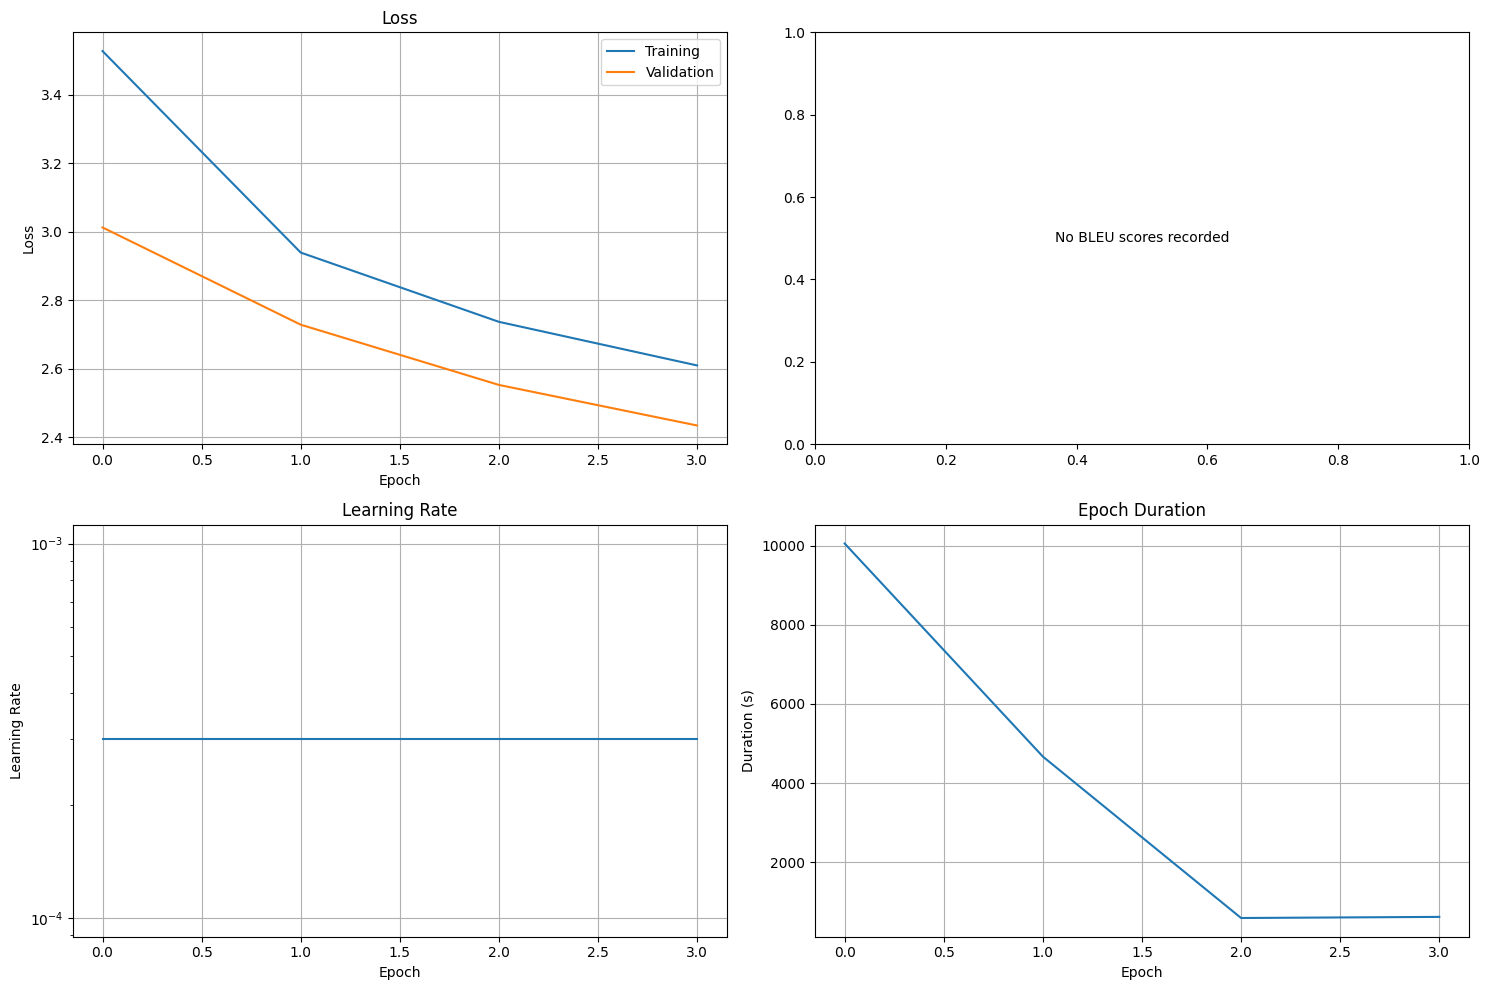

In [ ]:
# Plot training history
fig, axs = trainer.plot_history()
plt.show()

In [ ]:
# Find best epoch
best_epoch = np.argmin(trainer.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Best validation loss: {trainer.history['val_loss'][best_epoch]:.4f}")

# If BLEU scores were calculated
bleu_epochs = [i for i, bleu in enumerate(trainer.history['val_bleu']) if bleu > 0]
if bleu_epochs:
    best_bleu_epoch = bleu_epochs[np.argmax([trainer.history['val_bleu'][i] for i in bleu_epochs])]
    print(f"Best BLEU epoch: {best_bleu_epoch + 1}")
    print(f"Best BLEU score: {trainer.history['val_bleu'][best_bleu_epoch]:.4f}")

Best epoch: 4
Best validation loss: 2.4347


## 6. Generate Sample Captions

In [ ]:
import torch
from torch.serialization import safe_globals
from utils.vocabulary import Vocabulary

# Allow custom classes like Vocabulary in safe loading mode
with safe_globals([Vocabulary]):
    best_model_path = os.path.join(config['save_dir'], 'best_model_loss.pth')

    # Load the checkpoint manually
    checkpoint = torch.load(best_model_path, map_location=config['device'], weights_only=False)

    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])

    # Move model to device
    model = model.to(config['device'])

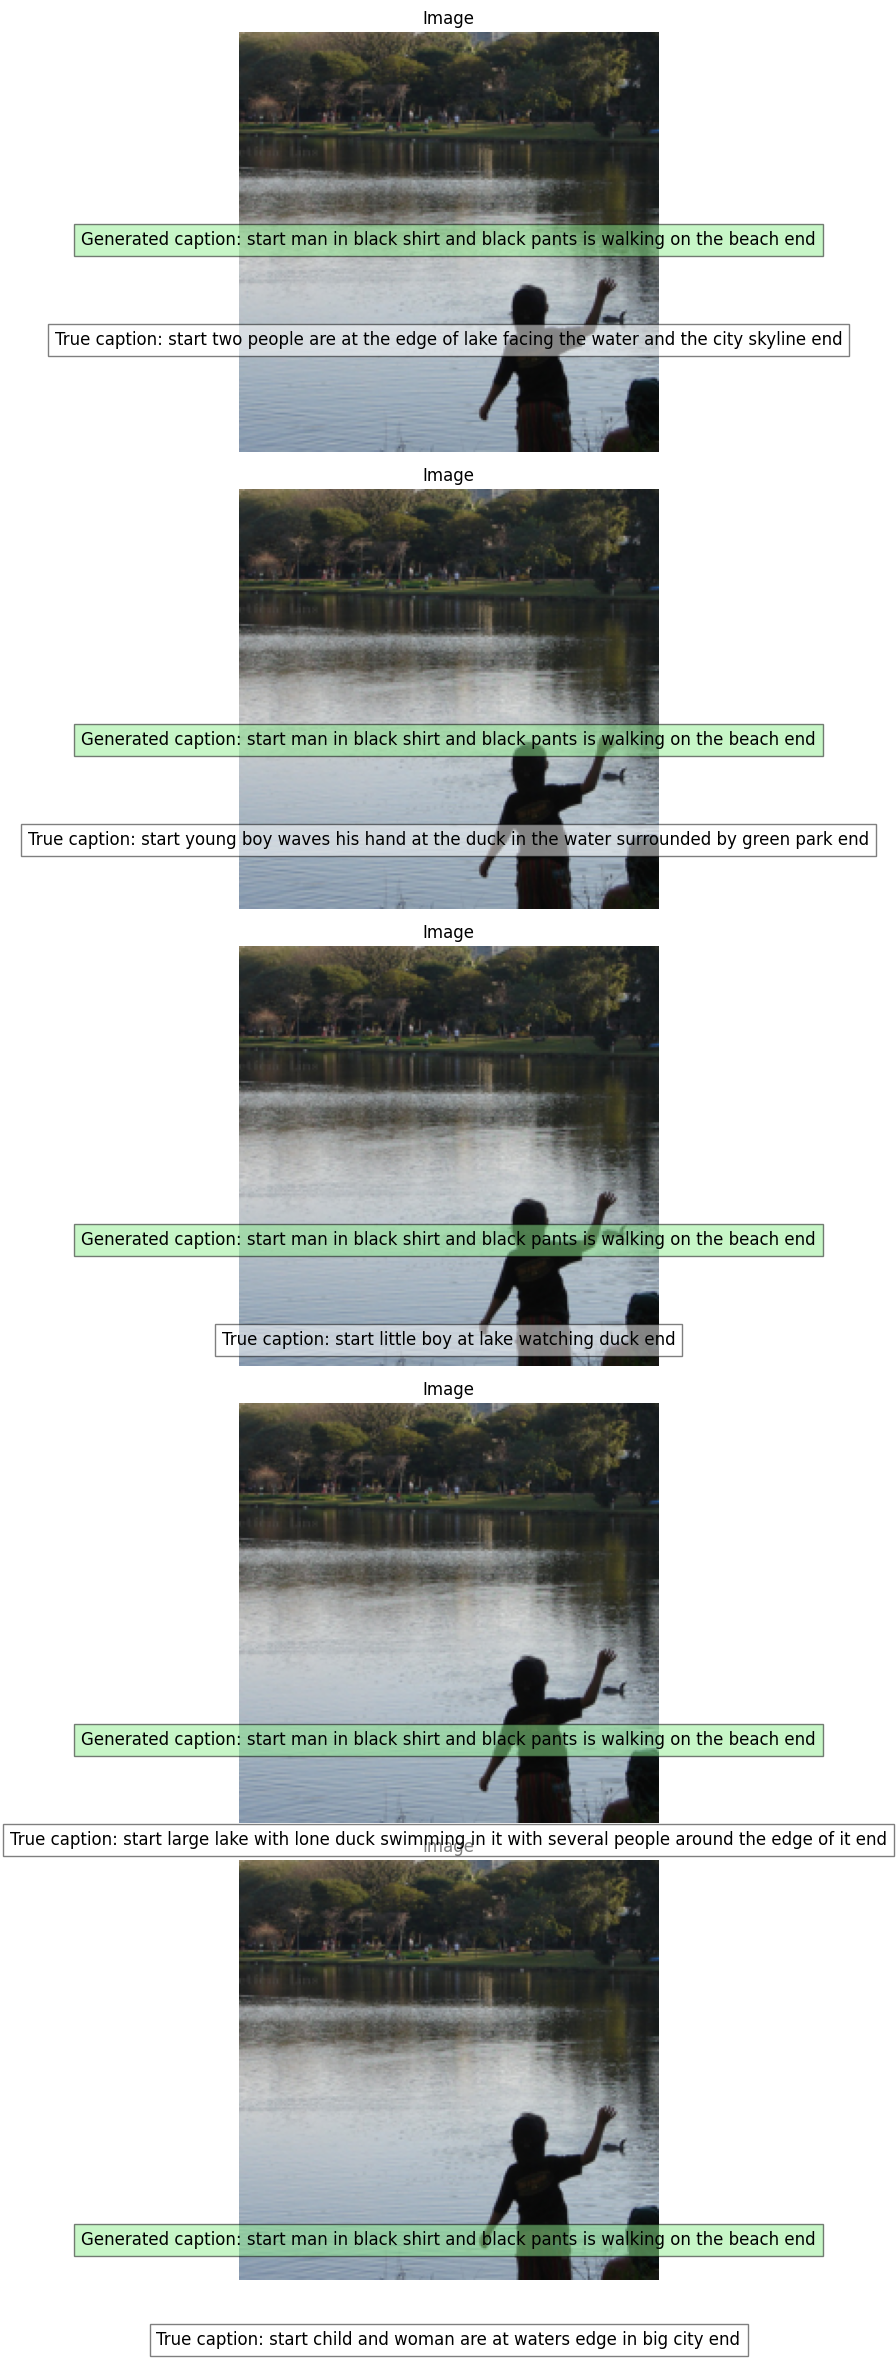

In [ ]:
# Generate captions for some validation images
def generate_caption(image, model, vocab, device):
    """Generate a caption for an image."""

    # TODO: Implement the caption generation function
    # 1. Set the model to evaluation mode
    # 2. Use torch.no_grad() to disable gradient calculation during inference
    # 3. Move the image to the device and add a batch dimension if needed
    # 4. Generate a caption using the model's generate_caption method
    # 5. Decode the caption indices to text using the vocabulary
    # 6. Return the caption text
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation during inference
        # Add batch dimension if needed and move to device
        if len(image.shape) == 3:
            image = image.unsqueeze(0)  # Add batch dimension: [1, C, H, W]
        image = image.to(device)

        # Generate a caption using the model's generate_caption method
        caption_indices = model.generate_caption(image)

        # Decode the caption indices to text using the vocabulary
        caption_text = vocab.decode(caption_indices, join=True, remove_special=True)

    return caption_text

# Get some validation examples
num_examples = 5
val_examples = []

for images, captions in val_loader:
    if len(val_examples) >= num_examples:
        break

    # Generate captions
    for i in range(len(images)):
        if len(val_examples) >= num_examples:
            break

        image = images[i]
        true_caption = vocab.decode(captions[i], join=True, remove_special=True)
        generated_caption = generate_caption(image, model, vocab, config['device'])
        val_examples.append({
    'image': image,
    'true_caption': true_caption,
    'generated_caption': generated_caption
})

# Display examples
plt.figure(figsize=(15, 5 * num_examples))

for i, example in enumerate(val_examples):
    plt.subplot(num_examples, 1, i + 1)

    # Convert tensor to image
    img = example['image'].permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')

    plt.figtext(0.5, 0.01 + i * (1/num_examples),
                f"True caption: {example['true_caption']}",
                ha='center', fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    plt.figtext(0.5, 0.05 + i * (1/num_examples),
                f"Generated caption: {example['generated_caption']}",
                ha='center', fontsize=12, bbox={"facecolor":"lightgreen", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 7. Compare Greedy and Beam Search Decoding

In [ ]:
import importlib
from models.decoder import DecoderRNN
import models.decoder

importlib.reload(models.decoder)

<module 'models.decoder' from '/content/drive/MyDrive/image_captioning/image-captioning/models/decoder.py'>

In [ ]:
# Compare greedy decoding vs. beam search
def compare_decoding_methods(image, model, vocab, device, beam_sizes=[1, 3, 5]):
    """Compare different beam search sizes for caption generation."""
    # TODO: Implement a function to compare different beam search settings
    # 1. Set the model to evaluation mode
    # 2. Initialize a dictionary to store results
    # 3. For each beam size:
    #    a. Generate a caption using that beam size
    #    b. Decode the caption indices to text
    #    c. Store the result in the dictionary
    # 4. Return the dictionary of results
    results = {}

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Add batch dimension if needed and move to device
        if len(image.shape) == 3:
            image = image.unsqueeze(0)  # [C, H, W] → [1, C, H, W]
        image = image.to(device)

        # For each beam size, generate a caption
        for beam_size in beam_sizes:
            caption_indices = model.generate_caption(image, beam_size=beam_size)
            caption_text = vocab.decode(caption_indices, join=True, remove_special=True)
            results[f'beam_{beam_size}'] = caption_text

    return results

# Select a random example from val_examples
import random
example = random.choice(val_examples)

# Compare decoding methods
beam_results = compare_decoding_methods(
    example['image'],
    model,
    vocab,
    config['device'],
    beam_sizes=[1, 3, 5]
)

# Display the image with different captions
plt.figure(figsize=(10, 10))

# Display image
img = example['image'].permute(1, 2, 0).numpy()
img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Denormalize
img = np.clip(img, 0, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {example['image_id']}")

# Add captions
captions = [
    f"True caption: {example['true_caption']}",
    f"Greedy search: {beam_results['beam_1']}",
    f"Beam search (k=3): {beam_results['beam_3']}",
    f"Beam search (k=5): {beam_results['beam_5']}"
]

# Display captions below the image
plt.figtext(0.5, 0.01, '\n'.join(captions), ha='center', fontsize=12,
            bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout(rect=[0, 0.2, 1, 0.95])
plt.show()

AttributeError: 'DecoderRNN' object has no attribute 'beam_search'

## 8. Save Final Model and Configuration

In [ ]:
# Save configuration
import json
config_path = os.path.join(config['save_dir'], 'config.json')

# Convert non-serializable values to strings
serializable_config = {k: str(v) if not isinstance(v, (int, float, str, bool)) else v
                      for k, v in config.items()}

with open(config_path, 'w') as f:
    json.dump(serializable_config, f, indent=4)

print(f"Configuration saved to {config_path}")

Configuration saved to /content/drive/MyDrive/image_captioning/image-captioning/models/config.json


In [ ]:
# Save vocabulary separately for easy access
import pickle
vocab_path = os.path.join(config['save_dir'], 'vocabulary.pkl')
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

print(f"Vocabulary saved to {vocab_path}")

Vocabulary saved to /content/drive/MyDrive/image_captioning/image-captioning/models/vocabulary.pkl


## Summary

In this notebook, we have successfully:

1. Set up the data loaders for training and validation
2. Built the caption model by combining the encoder and decoder
3. Trained the model with teacher forcing
4. Monitored the training progress and validation performance
5. Generated captions for sample images
6. Compared different decoding strategies (greedy vs. beam search)
7. Saved the model, configuration, and vocabulary for later use

In the next notebook, we will perform a comprehensive evaluation of the model on the test set.